# Super Resolution Vision Transformer (SRViT)

## Load Dataset

In [1]:
import os
from turtle import down
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from glob import glob

dataset_path = '/kaggle/input/brain-tumor-mri-images/Dataset'
categories = ["glioma", "healthy", "meningioma"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
downscale_factor = 4  # Factor by which to downscale the images

class MRIDataset(Dataset):
    def __init__(self, dataset_path, target_size=512, downscale_factor=2, augment=False) -> None:
        self.target_size = target_size
        self.downscale_factor = downscale_factor
        self.augment = augment
        self.image_paths = []

        for category in categories:
            self.image_paths.extend(sorted(glob(os.path.join(dataset_path, category, '*'))))
    
    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)

        # Check if the image was loaded successfully
        if img is None:
            raise ValueError(f"Image at index {idx} could not be read: {self.image_paths[idx]}")
        
        # Augment the image (vertical and horizontal flips)
        if self.augment:
            if np.random.rand() > 0.5:
                img = cv2.flip(img, 1) # Horizontal flip
            if np.random.rand() > 0.5:
                img = cv2.flip(img, 0) # Vertical flip

        # Generate LR and HR images pairs
        # Resize HR image to target size if it's not already that size
        if img.shape[0] != self.target_size or img.shape[1] != self.target_size:
            raise ValueError(f"Image at index {idx} has unexpected shape: {img.shape}. Expected shape: ({self.target_size}, {self.target_size})")
        hr_img = img.astype(np.float32) / 255.0
        lr_img = cv2.resize(
            img,
            (self.target_size // self.downscale_factor, self.target_size // self.downscale_factor),
            interpolation=cv2.INTER_CUBIC
        ) # Downscale the image by the downscale factor
        lr_img = lr_img.astype(np.float32) / 255.0 # Normalize to [0, 1] range

        # Convert to PyTorch tensors with channel dimension added
        hr_img_tensor = torch.from_numpy(hr_img[np.newaxis, :, :]) # shape (1, H, W)
        lr_img_tensor = torch.from_numpy(lr_img[np.newaxis, :, :])

        return lr_img_tensor, hr_img_tensor

full_dataset = MRIDataset(dataset_path, downscale_factor=downscale_factor, augment=True)
print(f"Dataset size: {len(full_dataset)} images")

Dataset size: 1596 images


Comparing LR and HR images downscaled by a factor of 4


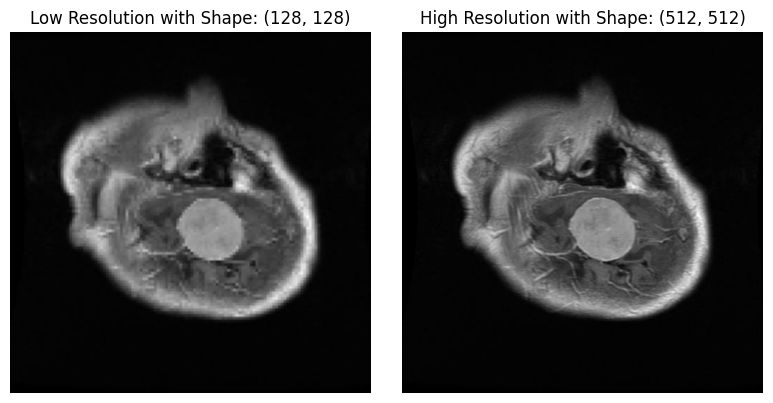

In [2]:
# Visualize some samples
import matplotlib.pyplot as plt

idx = np.random.randint(low=0, high=len(full_dataset))
lr_img, hr_img = full_dataset[idx]

print(f"Comparing LR and HR images downscaled by a factor of {downscale_factor}")

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(lr_img.squeeze(), cmap='gray')
axes[0].set_title(f'Low Resolution with Shape: {lr_img.shape[1], lr_img.shape[2]}')
axes[0].axis('off')
axes[1].imshow(hr_img.squeeze(), cmap='gray')
axes[1].set_title(f'High Resolution with Shape: {hr_img.shape[1], hr_img.shape[2]}')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## Split Datset into Train and Test Sets

In [3]:
from torch.utils.data import random_split

# Select train and test size
train_size = int(0.8 * len(full_dataset)) # 80% for training
test_size = len(full_dataset) - train_size # 20% for testing

# split dataset into train and test sets
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

print(f"Total images: {len(full_dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Total images: 1596
Training set size: 1276
Test set size: 320


In [4]:
# Creating DataLoaders for train and test sets
from torch.utils.data import DataLoader

BATCH_SIZE = 16
# Use half of the available CPU cores
NUM_WORKERS = os.cpu_count()
if NUM_WORKERS is not None:
    NUM_WORKERS //= 2  # Use half of the available CPU cores for DataLoader workers
else:
    NUM_WORKERS = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

## Model Architecture

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from itertools import repeat
import collections.abc
from typing import Tuple

import numpy as np

f"""
LMLT.py
"""

# Layer Norm
class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_first"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

# SE
class SqueezeExcitation(nn.Module):
    def __init__(self, dim, shrinkage_rate=0.25):
        super().__init__()
        hidden_dim = int(dim * shrinkage_rate)

        self.gate = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(dim, hidden_dim, 1, 1, 0),
            nn.GELU(),
            nn.Conv2d(hidden_dim, dim, 1, 1, 0),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.gate(x)


# Channel MLP: Conv1*1 -> Conv1*1
class ChannelMLP(nn.Module):
    def __init__(self, dim, growth_rate=2.0):
        super().__init__()
        hidden_dim = int(dim * growth_rate)

        self.mlp = nn.Sequential(
            nn.Conv2d(dim, hidden_dim, 1, 1, 0),
            nn.GELU(),
            nn.Conv2d(hidden_dim, dim, 1, 1, 0)
        )

    def forward(self, x):
        return self.mlp(x)


# MBConv: Conv1*1 -> DW Conv3*3 -> [SE] -> Conv1*1
class MBConv(nn.Module):
    def __init__(self, dim, growth_rate=2.0):
        super().__init__()
        hidden_dim = int(dim * growth_rate)

        self.mbconv = nn.Sequential(
            nn.Conv2d(dim, hidden_dim, 1, 1, 0),
            nn.GELU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, 1, 1, groups=hidden_dim),
            nn.GELU(),
            SqueezeExcitation(hidden_dim),
            nn.Conv2d(hidden_dim, dim, 1, 1, 0)
        )

    def forward(self, x):
        return self.mbconv(x)


# CCM
class CCM(nn.Module):
    def __init__(self, dim, growth_rate=2.0):
        super().__init__()
        hidden_dim = int(dim * growth_rate)

        self.ccm = nn.Sequential(
            nn.Conv2d(dim, hidden_dim, 3, 1, 1),
            nn.GELU(), 
            nn.Conv2d(hidden_dim, dim, 1, 1, 0)
        )

    def forward(self, x):
        return self.ccm(x)


def _ntuple(n):
    def parse(x):
        if isinstance(x, collections.abc.Iterable):
            return x
        return tuple(repeat(x, n))
    return parse


to_1tuple = _ntuple(1)
to_2tuple = _ntuple(2)
to_3tuple = _ntuple(3)
to_4tuple = _ntuple(4)
to_ntuple = _ntuple

class ConvPosEnc(nn.Module):
    """Depth-wise convolution to get the positional information.
    """
    def __init__(self, dim, k=3):
        super(ConvPosEnc, self).__init__()
        self.proj = nn.Conv2d(dim,
                              dim,
                              to_2tuple(k),
                              to_2tuple(1),
                              to_2tuple(k // 2),
                              groups=dim)

    def forward(self, x, size: Tuple[int, int]):
        B, N, C = x.shape
        H, W = size
        assert N == H * W

        feat = x.transpose(1, 2).view(B, C, H, W)
        feat = self.proj(feat)
        feat = feat.flatten(2).transpose(1, 2)
        x = x + feat
        return x
    

##############################################################
## Downsample ViT
class downsample_vit(nn.Module):
    def __init__(self, 
                 dim, 
                 window_size=8, 
                 attn_drop=0., 
                 proj_drop=0.,
                 down_scale=2,):
        super().__init__()
        
        self.dim = dim
        self.window_size = window_size
        self.scale = dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim*3)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        
        self.get_v = nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1,groups=dim)
        
    
    def window_partition(self, x, window_size):
        B, H, W, C = x.shape
        x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
        return x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    
    def window_reverse(self, windows, window_size, h, w):
        """
        Args:
            windows: (num_windows*b, window_size, window_size, c)
            window_size (int): Window size
            h (int): Height of image
            w (int): Width of image

        Returns:
            x: (b, h, w, c)
        """
        b = int(windows.shape[0] / (h * w / window_size / window_size))
        x = windows.view(b, h // window_size, w // window_size, window_size, window_size, -1)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(b, h, w, -1)
        return x
    
    
    def get_lepe(self, x, func):
        B, N, C = x.shape
        H = W = int(np.sqrt(N))
        x = x.transpose(-2,-1).contiguous().view(B, C, H, W)

        H_sp, W_sp = self.window_size, self.window_size
        x = x.view(B, C, H//H_sp, H_sp, W//W_sp, W_sp)
        x = x.permute(0, 2, 4, 1, 3, 5).contiguous().reshape(-1, C, H_sp, W_sp) ### B', C, H', W'

        lepe = func(x) ### B', C, H', W'
        lepe = lepe.reshape(-1, C, H_sp * W_sp).permute(0, 2, 1).contiguous()

        x = x.reshape(-1, C, H_sp* W_sp).permute(0, 2, 1).contiguous()
        return x, lepe
    
    
    def forward(self, x):
        B, C, H, W = x.shape
        
        ################################
        # 1. window partition
        ################################
        x = x.permute(0, 2, 3, 1)
        x_window = self.window_partition(x, self.window_size).permute(0,3,1,2)
        x_window = x_window.permute(0,2,3,1).view(-1, self.window_size * self.window_size, C)
        
        ################################
        # 2. make qkv
        ################################
        qkv = self.qkv(x_window)
        # qkv = qkv.permute(0,2,3,1)
        # qkv = qkv.reshape(-1, self.window_size * self.window_size, 3*C)
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        
        ################################
        # 3. attn and PE
        ################################
        v, lepe = self.get_lepe(v, self.get_v)
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v) + lepe
        # x = x.reshape(-1, self.window_size, self.window_size, C)
        # x = x.permute(0,3,1,2)
        
        ################################
        # 4. proj and drop
        ################################
        x = self.proj(x)
        x = self.proj_drop(x)

        x = x.reshape(-1, self.window_size, self.window_size, C)
        x = self.window_reverse(x, self.window_size, H, W)
        
        return x.permute(0,3,1,2)


##############################################################
## LHSB - split dim and define 4 attn blocks
class LHSB(nn.Module):
    def __init__(self,
                 dim,  
                 attn_drop=0.,
                 proj_drop=0.,
                 n_levels=4,):
        
        super().__init__()
        self.n_levels = n_levels
        chunk_dim = dim // n_levels

        # Spatial Weighting
        self.mfr = nn.ModuleList([
            downsample_vit(dim // 4,
                           window_size=8,
                           attn_drop=attn_drop,
                           proj_drop=proj_drop,
                           down_scale=2**i)
            for i in range(self.n_levels)])
        
        # # Feature Aggregation
        self.aggr = nn.Conv2d(dim, dim, 1, 1, 0)
        
        # Activation
        self.act = nn.GELU() 

    def forward(self, x):
        h, w = x.size()[-2:]

        xc = x.chunk(self.n_levels, dim=1)
        SA_before_idx = None
        out = []
        
        downsampled_feat = []
        for i in range(self.n_levels):
            if i > 0:
                p_size = (h//2**i, w//2**i)
                s = F.adaptive_max_pool2d(xc[i], p_size)
                downsampled_feat.append(s)

            else:
                downsampled_feat.append(xc[i])
        
        for i in reversed(range(self.n_levels)):
            s = self.mfr[i](downsampled_feat[i])
            s_upsample = F.interpolate(s, size=(s.shape[2]*2, s.shape[3]*2), mode='nearest')
            
            if i > 0:
                downsampled_feat[i-1] = downsampled_feat[i-1] + s_upsample
                
            s_original_shape = F.interpolate(s, size=(h, w), mode='nearest')
            out.append(s_original_shape)

        out = self.aggr(torch.cat(out, dim=1))
        out = self.act(out) * x
        return out

##############################################################
## Block
class AttBlock(nn.Module):
    def __init__(self, 
                 dim, 
                 ffn_scale=2.0, 
                 drop=0.,
                 attn_drop=0.,
                 drop_path=0.):
        
        super().__init__()

        self.norm1 = LayerNorm(dim) 
        self.norm2 = LayerNorm(dim) 

        # Multiscale Block
        self.lhsb = LHSB(dim, 
                         attn_drop=attn_drop, 
                         proj_drop=drop) 
        
        # Feedforward layer
        self.ccm = CCM(dim, ffn_scale) 

    def forward(self, x):
        x = self.lhsb(self.norm1(x)) + x
        x = self.ccm(self.norm2(x)) + x
        return x
        

##############################################################
## Overall Architecture
# @ARCH_REGISTRY.register()
class LMLT(nn.Module):
    def __init__(self,
        in_channels,
        dim, 
        n_blocks=8, 
        ffn_scale=2.0, 
        upscaling_factor=4,
        drop_rate=0., 
        attn_drop_rate=0.,
        drop_path_rate=0.,
    ):
        
        super().__init__()
        self.to_feat = nn.Conv2d(in_channels, dim, 3, 1, 1)
        self.window_size=8
        
        self.pos_drop = nn.Dropout(p=drop_rate)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, n_blocks)]  # stochastic depth decay rule
        
        self.feats = nn.Sequential(*[AttBlock(dim, 
                                              ffn_scale, 
                                              drop=drop_rate,
                                              attn_drop=attn_drop_rate,
                                              drop_path=dpr[i],
                                              ) 
                                     for i in range(n_blocks)])

        self.to_img = nn.Sequential(
            nn.Conv2d(dim, in_channels * upscaling_factor**2, 3, 1, 1),
            nn.PixelShuffle(upscaling_factor)
        )
        

    def check_img_size(self, x):
        _, _, h, w = x.size()
        downsample_scale = 8
        scaled_size = self.window_size * downsample_scale
        
        mod_pad_h = (scaled_size - h % scaled_size) % scaled_size
        mod_pad_w = (scaled_size - w % scaled_size) % scaled_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
        return x
        
        
    def forward(self, x):
        B, C, H, W = x.shape
        
        # check image size
        x = self.check_img_size(x)  
        
        # patch embed
        x = self.to_feat(x)
        
        # module, and return to original shape
        x = self.feats(x) + x
        x = x[:, :, :H, :W]
        
        # reconstruction
        x = self.to_img(x)
        return x

# Example usage
# if __name__== '__main__':
    #############Test Model Complexity #############
    # from fvcore.nn import flop_count_table, FlopCountAnalysis, ActivationCountAnalysis    
    # x = torch.randn(1, 3, 640, 360)
    # x = torch.randn(1, 3, 427, 240)
    # x = torch.randn(1, 3, 320, 180)
    # x = torch.randn(1, 3, 256, 256)

    # model = LMLT(dim=36, n_blocks=8, ffn_scale=2.0, upscaling_factor=2)
    # model = LMLT(dim=36, n_blocks=12, ffn_scale=2.0, upscaling_factor=2)
    # print(model)
    # print(f'params: {sum(map(lambda x: x.numel(), model.parameters()))}')
    # print(flop_count_table(FlopCountAnalysis(model, x), activations=ActivationCountAnalysis(model, x)))
    # output = model(x)
    # print(output.shape)

In [6]:
# Define Model and thier loss, optimizer, and learning rate scheduler in this cell for training

upscaling_factor = downscale_factor  # Set the upscaling factor to the downscale factor for consistency
model = LMLT(in_channels=1, dim=36, n_blocks=8, ffn_scale=2.0, upscaling_factor=upscaling_factor).to(device)

In [7]:
# print the model architecture
print(f"Model architecture:\n{model}")

Model architecture:
LMLT(
  (to_feat): Conv2d(1, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pos_drop): Dropout(p=0.0, inplace=False)
  (feats): Sequential(
    (0): AttBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (lhsb): LHSB(
        (mfr): ModuleList(
          (0-3): 4 x downsample_vit(
            (qkv): Linear(in_features=9, out_features=27, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=9, out_features=9, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (get_v): Conv2d(9, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=9)
          )
        )
        (aggr): Conv2d(36, 36, kernel_size=(1, 1), stride=(1, 1))
        (act): GELU(approximate='none')
      )
      (ccm): CCM(
        (ccm): Sequential(
          (0): Conv2d(36, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GELU(approximate='none')
          (2): Conv2d(72, 3

In [8]:
# print model parameters
print(f'params: {sum(map(lambda x: x.numel(), model.parameters()))/1000:.4f}K')

params: 239.9920K


## Model Training

In [9]:
from tqdm import tqdm

def train(model, loader, criterion, optimizer, scheduler, device, upscaling_factor, epochs=50):
    best_loss = float('inf')

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0

        for lr, hr in tqdm(loader, desc=f'Epoch {epoch}/{epochs}'):
            lr, hr = lr.to(device), hr.to(device)

            # Forward Pass
            sr = model(lr)
            loss = criterion(sr, hr)

            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(loader)
        scheduler.step(avg_loss)

        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), f'best_srvit_x{upscaling_factor}.pth')

        print(f"Epoch {epoch} | Loss: {avg_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

In [10]:
# Define Model and thier loss, optimizer, and learning rate scheduler in this cell for training

upscaling_factor = downscale_factor  # Set the upscaling factor to the downscale factor for consistency
model = LMLT(in_channels=1, dim=36, n_blocks=12, ffn_scale=2.0, upscaling_factor=upscaling_factor).to(device)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# Start training
train(model, train_loader, criterion, optimizer, scheduler, device, upscaling_factor, epochs=50)

Epoch 1/50: 100%|██████████| 80/80 [01:12<00:00,  1.10it/s]


Epoch 1 | Loss: 0.1015 | LR: 1.00e-04


Epoch 2/50: 100%|██████████| 80/80 [01:15<00:00,  1.06it/s]


Epoch 2 | Loss: 0.0393 | LR: 1.00e-04


Epoch 3/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 3 | Loss: 0.0291 | LR: 1.00e-04


Epoch 4/50: 100%|██████████| 80/80 [01:14<00:00,  1.08it/s]


Epoch 4 | Loss: 0.0242 | LR: 1.00e-04


Epoch 5/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 5 | Loss: 0.0212 | LR: 1.00e-04


Epoch 6/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 6 | Loss: 0.0192 | LR: 1.00e-04


Epoch 7/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 7 | Loss: 0.0179 | LR: 1.00e-04


Epoch 8/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 8 | Loss: 0.0169 | LR: 1.00e-04


Epoch 9/50: 100%|██████████| 80/80 [01:15<00:00,  1.07it/s]


Epoch 9 | Loss: 0.0161 | LR: 1.00e-04


Epoch 10/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 10 | Loss: 0.0156 | LR: 1.00e-04


Epoch 11/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 11 | Loss: 0.0150 | LR: 1.00e-04


Epoch 12/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 12 | Loss: 0.0146 | LR: 1.00e-04


Epoch 13/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 13 | Loss: 0.0144 | LR: 1.00e-04


Epoch 14/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 14 | Loss: 0.0140 | LR: 1.00e-04


Epoch 15/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 15 | Loss: 0.0137 | LR: 1.00e-04


Epoch 16/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 16 | Loss: 0.0135 | LR: 1.00e-04


Epoch 17/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 17 | Loss: 0.0134 | LR: 1.00e-04


Epoch 18/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 18 | Loss: 0.0131 | LR: 1.00e-04


Epoch 19/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 19 | Loss: 0.0130 | LR: 1.00e-04


Epoch 20/50: 100%|██████████| 80/80 [01:15<00:00,  1.07it/s]


Epoch 20 | Loss: 0.0129 | LR: 1.00e-04


Epoch 21/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 21 | Loss: 0.0128 | LR: 1.00e-04


Epoch 22/50: 100%|██████████| 80/80 [01:15<00:00,  1.07it/s]


Epoch 22 | Loss: 0.0127 | LR: 1.00e-04


Epoch 23/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 23 | Loss: 0.0126 | LR: 1.00e-04


Epoch 24/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 24 | Loss: 0.0125 | LR: 1.00e-04


Epoch 25/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 25 | Loss: 0.0124 | LR: 1.00e-04


Epoch 26/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 26 | Loss: 0.0124 | LR: 1.00e-04


Epoch 27/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 27 | Loss: 0.0122 | LR: 1.00e-04


Epoch 28/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 28 | Loss: 0.0122 | LR: 1.00e-04


Epoch 29/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 29 | Loss: 0.0121 | LR: 1.00e-04


Epoch 30/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 30 | Loss: 0.0120 | LR: 1.00e-04


Epoch 31/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 31 | Loss: 0.0120 | LR: 1.00e-04


Epoch 32/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 32 | Loss: 0.0120 | LR: 1.00e-04


Epoch 33/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 33 | Loss: 0.0120 | LR: 1.00e-04


Epoch 34/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 34 | Loss: 0.0119 | LR: 1.00e-04


Epoch 35/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 35 | Loss: 0.0119 | LR: 1.00e-04


Epoch 36/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 36 | Loss: 0.0118 | LR: 1.00e-04


Epoch 37/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 37 | Loss: 0.0117 | LR: 1.00e-04


Epoch 38/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 38 | Loss: 0.0118 | LR: 1.00e-04


Epoch 39/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 39 | Loss: 0.0117 | LR: 1.00e-04


Epoch 40/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 40 | Loss: 0.0116 | LR: 1.00e-04


Epoch 41/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 41 | Loss: 0.0117 | LR: 1.00e-04


Epoch 42/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 42 | Loss: 0.0116 | LR: 1.00e-04


Epoch 43/50: 100%|██████████| 80/80 [01:15<00:00,  1.06it/s]


Epoch 43 | Loss: 0.0116 | LR: 1.00e-04


Epoch 44/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 44 | Loss: 0.0116 | LR: 1.00e-04


Epoch 45/50: 100%|██████████| 80/80 [01:15<00:00,  1.06it/s]


Epoch 45 | Loss: 0.0115 | LR: 1.00e-04


Epoch 46/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 46 | Loss: 0.0115 | LR: 1.00e-04


Epoch 47/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 47 | Loss: 0.0115 | LR: 1.00e-04


Epoch 48/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 48 | Loss: 0.0118 | LR: 1.00e-04


Epoch 49/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


Epoch 49 | Loss: 0.0116 | LR: 1.00e-04


Epoch 50/50: 100%|██████████| 80/80 [01:14<00:00,  1.07it/s]

Epoch 50 | Loss: 0.0115 | LR: 1.00e-04


## Model Evaluation

In [11]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def evaluate(model, loader, device):
    model.eval() # Set the model to evaluation mode
    total_psnr, total_ssim = 0.0, 0.0
    num_samples = 0 # Track total number of samples evaluated

    with torch.no_grad(): # Disable gradient calculations during evaluation
        for lr, hr in tqdm(loader, desc='Evaluating...'):
            lr, hr = lr.to(device), hr.to(device)
            sr = model(lr) # Super-Resolution output

            # Iterate over each image in the batch
            for i in range(hr.shape[0]): # hr.shape[0] is the current batch size
                # Get single image and convert to numpy
                # .squeeze() removes any dimensions of size 1 (batch, channel)
                hr_np = hr[i].cpu().numpy().squeeze() 
                sr_np = sr[i].cpu().numpy().squeeze()

                # Calculate metrics for this single image
                total_psnr += psnr(hr_np, sr_np, data_range=1.0)
                total_ssim += ssim(hr_np, sr_np, data_range=1.0)
                num_samples += 1

    # Calculate average PSNR and SSIM over all evaluated samples
    if num_samples > 0:
        avg_psnr = total_psnr / num_samples
        avg_ssim = total_ssim / num_samples
    else:
        avg_psnr = 0.0
        avg_ssim = 0.0
        print("Warning: No samples were evaluated.")


    print(f"\nPSNR: {avg_psnr:.2f} dB")
    print(f"SSIM: {avg_ssim:.4f}")
        
    return avg_psnr, avg_ssim

In [12]:
upscaling_factor = downscale_factor  # Set the upscaling factor to the downscale factor for consistency
model = LMLT(in_channels=1, dim=36, n_blocks=12, ffn_scale=2.0, upscaling_factor=upscaling_factor).to(device)

# Evaluate the model
model.load_state_dict(torch.load(f'/kaggle/working/best_srvit_x4.pth'))
psnr_value, ssim_value = evaluate(model, test_loader, device)
print(f"Final PSNR: {psnr_value:.2f} dB")
print(f"Final SSIM: {ssim_value:.4f}")

Evaluating...: 100%|██████████| 320/320 [00:33<00:00,  9.42it/s]


PSNR: 32.96 dB
SSIM: 0.9260
Final PSNR: 32.96 dB
Final SSIM: 0.9260


In [13]:
train_psnr, train_ssim = evaluate(model, train_loader, device)

Evaluating...: 100%|██████████| 80/80 [01:15<00:00,  1.05it/s]


PSNR: 33.02 dB
SSIM: 0.9257


## Results

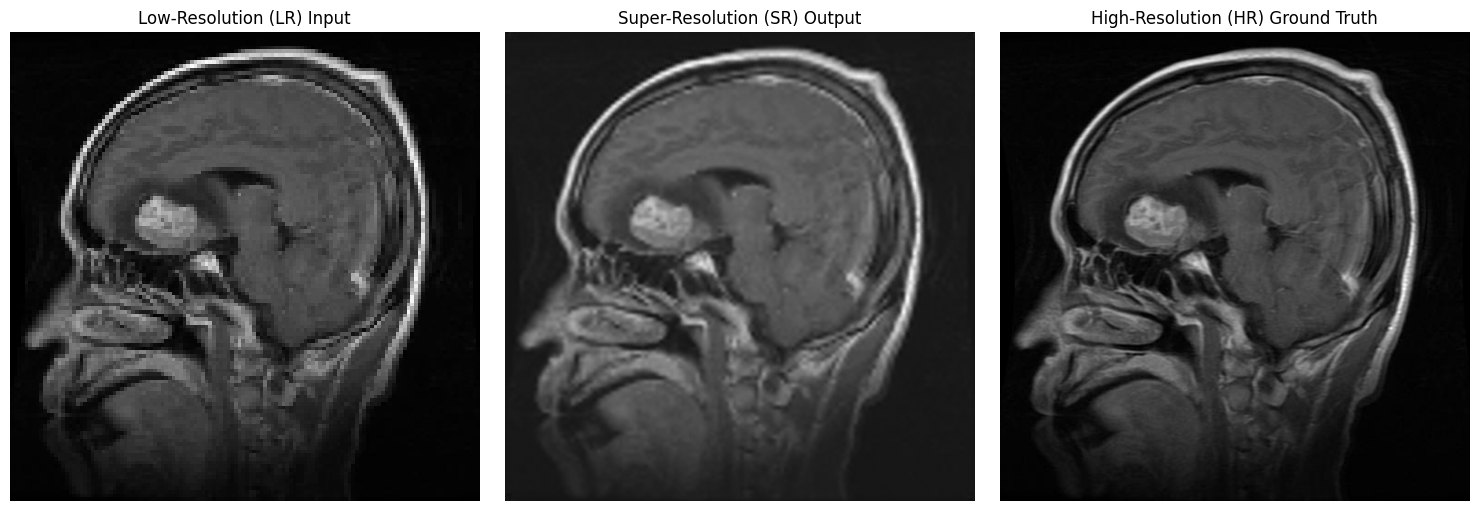

In [14]:
import matplotlib.pyplot as plt

def plot_results(lr, sr, hr):
    plt.figure(figsize=(15, 5))

    # Convert tensors to numpy arrays for plotting
    # Use .squeeze() to remove any single-dimensional entries (like the batch or channel dimension if it's 1)
    lr_np = lr.cpu().detach().squeeze().numpy() 
    sr_np = sr.cpu().detach().squeeze().numpy()
    hr_np = hr.cpu().detach().squeeze().numpy()

    # Low-Resolution Input
    plt.subplot(1, 3, 1)
    plt.title("Low-Resolution (LR) Input")
    plt.xlabel(f"{lr_np.shape[1]}x{lr_np.shape[0]} pixels") # Note: assuming HxW for imshow
    plt.imshow(lr_np, cmap='gray')
    plt.axis('off') # Optional: turn off axes for cleaner image display

    # Super-Resolution Output
    plt.subplot(1, 3, 2)
    plt.title("Super-Resolution (SR) Output")
    plt.xlabel(f"{sr_np.shape[1]}x{sr_np.shape[0]} pixels")
    plt.imshow(sr_np, cmap='gray')
    plt.axis('off')

    # High-Resolution Ground Truth
    plt.subplot(1, 3, 3)
    plt.title("High-Resolution (HR) Ground Truth")
    plt.xlabel(f"{hr_np.shape[1]}x{hr_np.shape[0]} pixels")
    plt.imshow(hr_np, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Test on sample
model.eval()
sample_lr, sample_hr = next(iter(test_loader))

with torch.no_grad():
    sample_sr = model(sample_lr.to(device))

plot_results(sample_lr[0], sample_sr[0], sample_hr[0])